### N<sup>2</sup>bias
+ Binary classification model: trained on Nbias `0-Full Annotations` data
+ Named entity recognition model: trained on Nbias `1-Text-Classification` data

In [1]:
# Download Keras 2 versions of software
!pip install tensorflow-datasets==4.8 --quiet
!pip install tensorflow==2.15.0 --quiet
!pip install tf_keras==2.15.0 --quiet
!pip install tensorflow-text==2.15.0 --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 63.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorstore 0.1.69 requires ml-dtypes>=0.3.1, but you have ml-dtypes 0.2.0 which is incompatible.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.15.0 which is incompatib

In [2]:
# For BERT and other Transformer libraries we generally use Huggingface's implementations:
!pip install transformers==4.17 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 54.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 3.2.1 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.17.0 which is incompatible.


In [3]:
!pip install datasets --quiet
!pip install seqeval --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
sentence-transformers 3.2.1 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.17.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [4]:
import transformers
print(transformers.__version__)
import tensorflow
print(tensorflow.__version__)

4.17.0
2.15.0


In [5]:
import ast
from collections import Counter
from datasets import load_dataset, Dataset
from huggingface_hub import login
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pprint import pprint
import re
import seaborn as sns
from seqeval.metrics import accuracy_score, classification_report
seqeval_classification_report = classification_report
from sklearn.metrics import classification_report
sklearn_classification_report = classification_report
import tensorflow as tf
from tensorflow import keras
import torch
import tqdm
from transformers import (
    EarlyStoppingCallback,
    TFLongformerModel,
    LongformerTokenizerFast,
    LongformerForTokenClassification,
    LongformerConfig,
    Trainer,
    TrainingArguments,
)
from transformers.modeling_outputs import TokenClassifierOutput

In [6]:
# Mount Drive in order to save the model weights
import os
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


### Global Variables

In [7]:
RANDOM_STATE = 5678           # Control for experimentation
MODEL_MAX = 512               # Record text gets truncated based on this
MAX_TOKENS_TO_BE_SHORT = 50   # Breakpoint for "Short" and "Long" records

In [8]:
# Rough estimate of max text length
# NOTE: Truncating the text avoids errors when encoding
MAX_TEXT_LEN = MODEL_MAX * 4
print("MAX_TEXT_LEN:", MAX_TEXT_LEN)

MAX_TEXT_LEN: 2048


In [9]:
# Authenticate using Huggingface token
from google.colab import userdata
login(userdata.get("HF_TOKEN"))

### Longformer

In [10]:
lf_tokenizer = LongformerTokenizerFast.from_pretrained(
    "allenai/longformer-base-4096",
    add_prefix_space=True,
)
print("Successfully instantiated LongformerTokenizerFast")

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/694 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Successfully instantiated LongformerTokenizerFast


### Dataset: NBias

In [11]:
# 0. Full Annotations
full_train = load_dataset("shainar/BEAD", data_files="0-Full Annotations/Full.csv")["train"]
full_train_df = full_train.to_pandas()

README.md:   0%|          | 0.00/6.82k [00:00<?, ?B/s]

Full.csv:   0%|          | 0.00/1.03G [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [12]:
full_train_df.sample(2)

,text,dimension,biased_words,aspect,label,sentiment,toxic,identity_mention
178892,It feel so good after working out at the gym! ...,Ageism and sentiment,[],Body-shaming,Neutral,Positive,0.0,NO
3254741,Simple answer. When the feds get called into i...,toxicity,[],News Media,Neutral,Positive,0.0,gender male


In [13]:
# Drop where "text" is null
full_train_df_cleaned = full_train_df.dropna(subset=["text"])
print(f"Dropping null 'text' reduced to {full_train_df_cleaned.shape[0]:,}/{full_train_df.shape[0]:,} rows...")
full_train_df_cleaned["label"].value_counts(dropna=False)

Dropping null 'text' reduced to 3,674,925/3,674,927 rows...


,count
label,
Neutral,1886251
Slightly Biased,1041254
Highly Biased,747420


In [14]:
# Calculate the number of characters, tokens, and then bucket into "Short" and "Long"
full_train_df_cleaned["text_len"] = full_train_df_cleaned["text"].apply(len)
full_train_df_cleaned["text_tokens"] = (full_train_df_cleaned["text_len"] / 4).round().astype(int)
full_train_df_cleaned["bucket"] = np.where(full_train_df_cleaned["text_tokens"] > MAX_TOKENS_TO_BE_SHORT, "Long", "Short")
full_train_df_cleaned.sample(2)

<ipython-input-14-014b852690b4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_train_df_cleaned["text_len"] = full_train_df_cleaned["text"].apply(len)
<ipython-input-14-014b852690b4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_train_df_cleaned["text_tokens"] = (full_train_df_cleaned["text_len"] / 4).round().astype(int)
<ipython-input-14-014b852690b4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

,text,dimension,biased_words,aspect,label,sentiment,toxic,identity_mention,text_len,text_tokens,bucket
1643304,take this news quiz: http://bit.ly/Hhf6E . I...,Ageism and sentiment,[],News Media,Slightly Biased,Negative,0.0,NO,121,30,Short
2127487,I get bad reception in this store.,Ageism and sentiment,[],News Media,Slightly Biased,Negative,0.0,NO,35,9,Short


In [15]:
full_train_df_cleaned["bucket"].value_counts(dropna=False)

,count
bucket,
Short,2624110
Long,1050815


In [16]:
# Reduce to the records that are in a "confident" classification (e.g., drop Slightly biased)
limited_train_df = full_train_df_cleaned[full_train_df_cleaned["label"].isin(["Neutral", "Highly Biased"])]
print(f"Reduced to {limited_train_df.shape[0]:,} rows from {full_train_df_cleaned.shape[0]:,}")
limited_train_df["bucket"].value_counts(dropna=False)

Reduced to 2,633,671 rows from 3,674,925


,count
bucket,
Short,1941584
Long,692087


In [17]:
# Balance the dataset to exactly as many "Short" as "Long" records
sample_size = 100000
short_df = limited_train_df[limited_train_df["bucket"] == "Short"]
long_df = limited_train_df[limited_train_df["bucket"] == "Long"]
short_sampled = short_df.sample(n=int(sample_size/2), random_state=RANDOM_STATE)
long_sampled = long_df.sample(n=int(sample_size/2), random_state=RANDOM_STATE)
balanced_df = pd.concat([short_sampled, long_sampled])

# Shuffle the combined df
balanced_df = balanced_df.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)
print(f"After balancing Short and Long, left with {balanced_df.shape[0]:,}/{limited_train_df.shape[0]:,} rows")

# Binary label column "label_int"
balanced_df["label_int"] = np.where(balanced_df["label"] == "Neutral", 0, 1)
balanced_df["label_int"].value_counts(dropna=False)

After balancing Short and Long, left with 100,000/2,633,671 rows


,count
label_int,
0,59910
1,40090


[Nbias training parameters](https://arxiv.org/pdf/2308.01681?#page=16)
+ bert-base-uncased
+ Adam
+ Learning Rate 1 × 10−2
+ Momentum 0.5
+ Weight Decay 0.01
+ Epochs 5
+ Batch Sizes 4, 8, 16, 32, 64
+ Batch Size (training) 16
+ Input Sequence Length 128 subword tokens
+ Dropout Applied on input and hidden layers
+ Convergence Criteria Negligible decrease in validation loss
+ Validation Strategy Hold-out
+ Early Stopping Implemented
+ Training Environment Google Colab Pro
+ Hardware NVIDIA Tesla T4 GPU
+ β1 0.9
+ β2 0.999
+ Epsilon 1 × 10−8
+ Hidden Units (Leaky) Rectified Linear Units (ReLUs)

In [18]:
### Comment this top section out to run the whole set
# # Shuffle the DataFrame
# # For getting set up purposes, limiting to N records, retaining equal weight of short and long
# sample_n = 2000
# half_n = int(sample_n / 2)
# short_df = balanced_df[balanced_df["bucket"] == "Short"]
# long_df = balanced_df[balanced_df["bucket"] == "Long"]
# short_sampled = short_df.sample(n=half_n, random_state=RANDOM_STATE)
# long_sampled = long_df.sample(n=half_n, random_state=RANDOM_STATE)
# balanced_df = pd.concat([short_sampled, long_sampled])

# # Shuffle the combined df
# balanced_df = balanced_df.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)
# print(f"After balancing Short and Long, left with {balanced_df.shape[0]:,}/{limited_train_df.shape[0]:,} rows")

# # Binary label column "label_int"
# balanced_df["label_int"] = np.where(balanced_df["label"] == "Neutral", 0, 1)

### Train/val/test split

# Define split sizes
train, test, val = 0.5, 0.25, 0.25

# Calculate indices for splitting
n = balanced_df.shape[0]
train_end = int(n * train)
test_end = train_end + int(n * test)

# Split the DataFrame
train_df = balanced_df.iloc[:train_end]
test_df = balanced_df.iloc[train_end:test_end]
val_df = balanced_df.iloc[test_end:]

# Print the sizes of the splits
print(f"Train size: {len(train_df)}")
print(f"Test size: {len(test_df)}")
print(f"Validation size: {len(val_df)}")

Train size: 50000
Test size: 25000
Validation size: 25000


In [20]:
### Input text and labels
    # Ensure all elements are strings and within token limits
    # For text inputs, List[str] as input, not array[str]
    # For label inputs, array[int]
train_text = train_df["text"].str[:MAX_TEXT_LEN].to_list()
train_labels = train_df["label_int"].to_numpy()
train_bucket = train_df["bucket"].to_numpy()
print(f"Train text, labels, bucket: {len(train_text)}, {len(train_labels)}, {len(train_bucket)}")

val_text = val_df["text"].str[:MAX_TEXT_LEN].to_list()
val_labels = val_df["label_int"].to_numpy()
val_bucket = val_df["bucket"].to_numpy()
print(f"Validation text, labels, bucket: {len(val_text)}, {len(val_labels)}, {len(val_bucket)}")

test_text = test_df["text"].str[:MAX_TEXT_LEN].to_list()
test_labels = test_df["label_int"].to_numpy()
test_bucket = test_df["bucket"].to_numpy()
print(f"Test text, labels, bucket: {len(test_text)}, {len(test_labels)}, {len(test_bucket)}")

Train text, labels, bucket: 50000, 50000, 50000
Validation text, labels, bucket: 25000, 25000, 25000
Test text, labels, bucket: 25000, 25000, 25000


In [21]:
# Tokenize the datasets, truncating, pad with zeroes
train_encodings = lf_tokenizer(
    list(tqdm.tqdm(train_text, desc="Tokenizing train data")),
    truncation=True,
    is_split_into_words=False,
    padding="max_length",
    max_length=MODEL_MAX,
    return_tensors="pt",
    return_offsets_mapping=True,
)
val_encodings = lf_tokenizer(
    list(tqdm.tqdm(val_text, desc="Tokenizing validation data")),
    truncation=True,
    is_split_into_words=False,
    padding="max_length",
    max_length=MODEL_MAX,
    return_tensors="pt",
    return_offsets_mapping=True,
)
test_encodings = lf_tokenizer(
    list(tqdm.tqdm(test_text, desc="Tokenizing test data")),
    truncation=True,
    is_split_into_words=False,
    padding="max_length",
    max_length=MODEL_MAX,
    return_tensors="pt",
    return_offsets_mapping=True,
)

print(train_encodings.input_ids.shape)
print(val_encodings.input_ids.shape)
print(test_encodings.input_ids.shape)

Tokenizing test data: 100%|██████████| 25000/25000 [00:00<00:00, 2256652.18it/s]


torch.Size([50000, 512])
torch.Size([25000, 512])
torch.Size([25000, 512])


In [22]:
def longformer_binary_model(
    checkpoint="allenai/longformer-base-4096",
    num_classes=2,
    hidden_size=MODEL_MAX+1,
    dropout=0.2,
    learning_rate=0.00005,
    max_sequence_length=MODEL_MAX,
):
    """
    Build a binary classification model with Longformer. Use the [CLS] token for classification.
    """

    # Load Longformer model
    longformer_model = TFLongformerModel.from_pretrained(checkpoint)
    longformer_model.trainable = True

    # Input layers
    input_ids_layer = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int32, name="input_ids_layer")
    attention_mask_layer = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int32, name="attention_mask_layer")

    # Longformer output
    longformer_out = longformer_model({
        "input_ids": input_ids_layer,
        "attention_mask": attention_mask_layer,
    })

    # [CLS] token
    cls_token = longformer_out.last_hidden_state[:, 0, :]

    # Classification head
    hidden = tf.keras.layers.Dense(hidden_size, activation="relu", name="hidden_layer_1")(cls_token)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)
    hidden = tf.keras.layers.Dense(hidden_size // 2, activation="relu", name="hidden_layer_2")(hidden)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)
    classification = tf.keras.layers.Dense(1, activation="sigmoid", name="classification_layer")(hidden)

    # Build and compile the model
    classification_model = tf.keras.Model(
        inputs=[input_ids_layer, attention_mask_layer],
        outputs=[classification]
    )
    classification_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=["accuracy"]
    )
    return classification_model

In [ ]:
# Load model
lf_model = longformer_binary_model()

Downloading:   0%|          | 0.00/729M [00:00<?, ?B/s]

Some layers from the model checkpoint at allenai/longformer-base-4096 were not used when initializing TFLongformerModel: ['lm_head']
- This IS expected if you are initializing TFLongformerModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFLongformerModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFLongformerModel were initialized from the model checkpoint at allenai/longformer-base-4096.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFLongformerModel for predictions without further training.


In [ ]:
lf_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask_layer (Inpu  [(None, 512)]                0         []                            
 tLayer)                                                                                          
                                                                                                  
 input_ids_layer (InputLaye  [(None, 512)]                0         []                            
 r)                                                                                               
                                                                                                  
 tf_longformer_model (TFLon  TFLongformerBaseModelOutpu   1486594   ['attention_mask_layer[0][0]',
 gformerModel)               tWithPooling(last_hidden_s   56         'input_ids_layer[0][0]'] 

In [ ]:
### On Colab Pro A100 GPU
# with batch_size=4, 1 hidden layer
    # ~2 minutes to complete 1 epoch for a sample size 1,000
# with batch_size=16, 2 hidden layer
    # ~2 minutes to complete 1 epoch for a sample size 1,000
    # ~3 minutes to complete 1 epoch for a sample size 2,000
# with batch_size=16, 2 hidden layers
    # ~2 minutes to complete 1 epoch for a sample size 2,000
# with batch_size=16, 2 hidden layers
    # ~5 minutes to complete 5 epochs for a sample size 2,000
# with batch_size=8, 2 hidden layers
    # ~5 minutes to complete 5 epochs for a sample size 2,000
# with batch_size=8, 2 hidden layers
    # ~14 minutes to complete 1 epoch for train set of 18,712
# with batch_size=16, 2 hidden layers
    # ~55 minutes to complete 5 epochs for train set of 18,712
# DEBUGGING 11/30 with batch_size=4, 2 hidden layers
    # ~1 minutes to complete 1 epoch for train set of 50
# DEBUGGING 11/30 with batch_size=16, 2 hidden layers
    # ~1 minutes to complete 2 epochs for train set of 500
# FULL RUN with batch_size=16, 2 hidden layers
    # ~55 minutes to complete 5 epochs for train set of 18,712


# Convert BatchEncoding to a plain dictionary
# Ensure all tensors in train_features and train_labels are tf.int32 or tf.float32 (depending on the context).
# NOTE: The dict keys must match the input names in the model
# E.g., Must be "input_ids_layer", "attention_mask_layer" not "input_ids", "attention_mask")
train_features = {
    "input_ids_layer": tf.convert_to_tensor(train_encodings["input_ids"], dtype=tf.int32),
    "attention_mask_layer": tf.convert_to_tensor(train_encodings["attention_mask"], dtype=tf.int32)
}
train_labels = tf.convert_to_tensor(train_labels, dtype=tf.float32)
val_features = {
    "input_ids_layer": tf.convert_to_tensor(val_encodings["input_ids"], dtype=tf.int32),
    "attention_mask_layer": tf.convert_to_tensor(val_encodings["attention_mask"], dtype=tf.int32)
}
val_labels = tf.convert_to_tensor(val_labels, dtype=tf.float32)

# Create TensorFlow datasets
batch_size = 16
train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_features, train_labels)
    ).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices(
    (val_features, val_labels)
    ).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Train the model
history = lf_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,
    verbose=1,
)

Epoch 1/5


1170/1170 [==============================] - 1201s 941ms/step - loss: 0.2615 - accuracy: 0.8992 - val_loss: 0.1987 - val_accuracy: 0.9313
Epoch 2/5
1170/1170 [==============================] - 1076s 919ms/step - loss: 0.1666 - accuracy: 0.9415 - val_loss: 0.1616 - val_accuracy: 0.9482
Epoch 3/5
1170/1170 [==============================] - 1076s 920ms/step - loss: 0.1125 - accuracy: 0.9621 - val_loss: 0.2652 - val_accuracy: 0.9300
Epoch 4/5
1170/1170 [==============================] - 1076s 920ms/step - loss: 0.0778 - accuracy: 0.9748 - val_loss: 0.1829 - val_accuracy: 0.9509
Epoch 5/5
1170/1170 [==============================] - 1076s 920ms/step - loss: 0.0557 - accuracy: 0.9836 - val_loss: 0.1849 - val_accuracy: 0.9474


### Store the Model

In [23]:
lf_bin_cls_weights_path = "/content/drive/My Drive/Berkeley MIDS/DATASCI 266 Natural Language Processing/Models/lf_bin_cls_weights.h5"
# lf_bin_cls_weights_path = "/content/drive/My Drive/Berkeley MIDS/DATASCI 266 Natural Language Processing/Debugging Models/lf_bin_cls_weights.h5"

# Print contents of folder
folder_path = "/content/drive/My Drive/Berkeley MIDS/DATASCI 266 Natural Language Processing/Models"
# folder_path = "/content/drive/My Drive/Berkeley MIDS/DATASCI 266 Natural Language Processing/Debugging Models"
print("Folder contents:", os.listdir(folder_path))

Folder contents: ['lf_bin_cls_weights_1epoch.h5', 'lf_bin_cls_weights.h5', 'lf_ner_weights_v1.h5', 'lf_ner_weights.h5']


In [ ]:
# Save the model weights
lf_model.save_weights(lf_bin_cls_weights_path)
print("File exists:", os.path.isfile(lf_bin_cls_weights_path))
print("Folder contents:", os.listdir(folder_path))

File exists: True
Folder contents: ['lf_bin_cls_weights_1epoch.h5', 'lf_bin_cls_weights.h5', 'lf_ner_weights.h5']


In [24]:
# Reinitialize the model and load from saved weights
lf_model2 = longformer_binary_model()
lf_model2.load_weights(lf_bin_cls_weights_path)

Downloading:   0%|          | 0.00/729M [00:00<?, ?B/s]

Some layers from the model checkpoint at allenai/longformer-base-4096 were not used when initializing TFLongformerModel: ['lm_head']
- This IS expected if you are initializing TFLongformerModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFLongformerModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFLongformerModel were initialized from the model checkpoint at allenai/longformer-base-4096.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFLongformerModel for predictions without further training.


In [25]:
# Test dataset
test_features = {
    "input_ids_layer": tf.convert_to_tensor(test_encodings["input_ids"], dtype=tf.int32),
    "attention_mask_layer": tf.convert_to_tensor(test_encodings["attention_mask"], dtype=tf.int32)
}
test_labels = tf.convert_to_tensor(test_labels, dtype=tf.float32)

In [26]:
# Evaluate the test dataset
lf_score = lf_model2.evaluate(
    [
        test_features["input_ids_layer"],
        test_features["attention_mask_layer"],
    ],
    test_labels
)
print("Test loss:", lf_score[0])
print("Test accuracy:", lf_score[1])

782/782 [==============================] - 546s 661ms/step - loss: 0.2516 - accuracy: 0.9308
Test loss: 0.2516259551048279
Test accuracy: 0.930840015411377


In [27]:
"""
SAMPLES
#1    (Rand State 1234 with 10,000 sample) learning rate 0.00005, 1 epochs, test accuracy of 0.71000 and loss of 0.59560
#2    (Rand State 1234 with 1,000  sample) learning rate 0.00005, 1 epochs, test accuracy of 0.68000 and loss of 0.62539
#3    (Rand State 1234 with 1,000  sample) learning rate 0.00010, 1 epochs, test accuracy of 0.83499 and loss of 0.45770
#4    (Rand State 1234 with 1,000  sample) learning rate 0.00010, 1 epochs, test accuracy of 0.76999 and loss of 0.52738
#5    (Rand State 1234 with 2,000  sample) learning rate 0.00010, 1 epochs, test accuracy of 0.68985 and loss of 0.54500
    ***I added a second hidden layer with half the density between samples 5-6 I
#6    (Rand State 1234 with 2,000  sample) learning rate 0.00010, 1 epochs, test accuracy of 0.85000 and loss of 0.33756
#7    (Rand State 1234 with 2,000  sample) learning rate 0.00010, 5 epochs, test accuracy of 0.45500 and loss of 0.91419
#8    (Rand State 1234 with 2,000  sample) learning rate 0.00005, 5 epochs, test accuracy of 0.88499 and loss of 0.42710

FULL RUN 11/29
#9    (Rand State 1234 with 18,712 full set) learning rate 0.00005, 5 epochs, test accuracy of 0.95361 and loss of 0.21385
      ***55 minutes to complete
#10   (Rand State 1234 with 50 debugging set) learning rate 0.00005, 1 epoch, test accuracy of 0.87999 and loss of 0.60473
#11   (Rand State 1234 with 500 debugging set) learning rate 0.00005, 2 epochs, test accuracy of 0.82599 and loss of 0.59150

FULL RUN 11/29
#9    (Rand State 1234 with 18,712 full set) learning rate 0.00005, 5 epochs, test accuracy of 0.94624 and loss of 0.18489
      ***91 minutes to complete
"""

'\nSAMPLES\n#1    (Rand State 1234 with 10,000 sample) learning rate 0.00005, 1 epochs, test accuracy of 0.71000 and loss of 0.59560\n#2    (Rand State 1234 with 1,000  sample) learning rate 0.00005, 1 epochs, test accuracy of 0.68000 and loss of 0.62539\n#3    (Rand State 1234 with 1,000  sample) learning rate 0.00010, 1 epochs, test accuracy of 0.83499 and loss of 0.45770\n#4    (Rand State 1234 with 1,000  sample) learning rate 0.00010, 1 epochs, test accuracy of 0.76999 and loss of 0.52738\n#5    (Rand State 1234 with 2,000  sample) learning rate 0.00010, 1 epochs, test accuracy of 0.68985 and loss of 0.54500\n    ***I added a second hidden layer with half the density between samples 5-6 I\n#6    (Rand State 1234 with 2,000  sample) learning rate 0.00010, 1 epochs, test accuracy of 0.85000 and loss of 0.33756\n#7    (Rand State 1234 with 2,000  sample) learning rate 0.00010, 5 epochs, test accuracy of 0.45500 and loss of 0.91419\n#8    (Rand State 1234 with 2,000  sample) learning 

In [28]:
# Predict for the all records in the test data set
batch_size = 16
test_dataset = tf.data.Dataset.from_tensor_slices(
    (test_features, test_labels)
    ).batch(batch_size).prefetch(tf.data.AUTOTUNE)
predictions = lf_model2.predict(test_dataset)

1563/1563 [==============================] - 553s 343ms/step


In [29]:
print("11/16 morning -- Model isn't learning. All predictions between 0.24-0.27 UGH.")
print("11/16 afternoon -- Getting better with higher learning rate, 0.21-0.75")
print("11/18 evening -- YAYYY much better, with the second hidden layer we're now into the 0.04-0.97 range!")
print("11/27 -- Training with lr of 0.00005 and batch size 8 did well, 0.01-0.99 range")
print("11/29 full run -- 0.0002-0.9997 range")
print("11/30 debugging v1 -- 0.3760-0.9671 range")
print("11/30 debugging v2 -- 0.0024-0.9984 range")
print("11/30 full run -- 0.0020-0.9993 range")
print("Min:", min(predictions)[0])
print("Max:", max(predictions)[0])

11/16 morning -- Model isn't learning. All predictions between 0.24-0.27 UGH.
11/16 afternoon -- Getting better with higher learning rate, 0.21-0.75
11/18 evening -- YAYYY much better, with the second hidden layer we're now into the 0.04-0.97 range!
11/27 -- Training with lr of 0.00005 and batch size 8 did well, 0.01-0.99 range
11/29 full run -- 0.0002-0.9997 range
11/30 debugging v1 -- 0.3760-0.9671 range
11/30 debugging v2 -- 0.0024-0.9984 range
11/30 full run -- 0.0020-0.9993 range
Min: 0.002013286
Max: 0.9993057


In [30]:
# Convert prediction arrays to binary 0, 1 elements
prediction_labels = predictions.squeeze()
prediction_labels = (prediction_labels > 0.5).astype(int)

# Value counts
uniques, counts = np.unique(prediction_labels, return_counts=True)
print("Model predictions:")
print(f"{uniques[0]}:{counts[0]} ({round(counts[0]/sum(counts)*100, 1)}%)")
print(f"{uniques[1]}:{counts[1]} ({round(counts[1]/sum(counts)*100, 1)}%)")

Model predictions:
0:16071 (64.3%)
1:8929 (35.7%)


In [31]:
# Actual labels
uniques, counts = np.unique(test_labels, return_counts=True)
print("Actual labels:")
print(f"{uniques[0]}:{counts[0]} ({round(counts[0]/sum(counts)*100, 1)}%)")
print(f"{uniques[1]}:{counts[1]} ({round(counts[1]/sum(counts)*100, 1)}%)")

Actual labels:
0.0:14988 (60.0%)
1.0:10012 (40.0%)


In [ ]:
print(sklearn_classification_report(
    test_labels,
    prediction_labels,
    target_names=["Neutral", "Highly Biased"],
    digits=5,
))

               precision    recall  f1-score   support

      Neutral    0.91251   0.97845   0.94433     14988
Highly Biased    0.96383   0.85957   0.90872     10012

     accuracy                        0.93084     25000
    macro avg    0.93817   0.91901   0.92652     25000
 weighted avg    0.93306   0.93084   0.93007     25000



In [32]:
# Plot confusion matrix
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(4, 4))
    sns.heatmap(
        cm,
        annot=True,
        xticklabels=["Neutral", "Biased"],
        yticklabels=["Neutral", "Biased"],
    )
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

In [33]:
# Convert to numpy arrays for filtering
test_labels = tf.convert_to_tensor(test_labels).numpy()
prediction_labels = tf.convert_to_tensor(prediction_labels).numpy()

# Separate "Short" and "Long" records
short_mask = (test_bucket == "Short")
long_mask = (test_bucket == "Long")

# Confusion matrix for all records
all_cm = tf.math.confusion_matrix(
    test_labels,
    prediction_labels,
)
all_cm_normalized = all_cm/all_cm.numpy().sum(axis=1)[:, tf.newaxis]

# Confusion matrix for "Short" records
short_cm = tf.math.confusion_matrix(
    test_labels[short_mask],
    prediction_labels[short_mask],
)
short_cm_normalized = short_cm / short_cm.numpy().sum(axis=1)[:, tf.newaxis]

# Confusion matrix for "Long" records
long_cm = tf.math.confusion_matrix(
    test_labels[long_mask],
    prediction_labels[long_mask],
)
long_cm_normalized = long_cm / long_cm.numpy().sum(axis=1)[:, tf.newaxis]

In [37]:
### Accuracy scores for overall, short, long

# Overall accuracy
correct_predictions = tf.reduce_sum(tf.cast(test_labels == prediction_labels, tf.float32))
total_predictions = tf.cast(tf.size(test_labels), tf.float32)
print("Overall accuracy:", correct_predictions / total_predictions)

test_labels[short_mask]
prediction_labels[short_mask]

# Short accuracy
correct_short_predictions = tf.reduce_sum(tf.cast(test_labels[short_mask] == prediction_labels[short_mask], tf.float32))
total_short_predictions = tf.cast(tf.size(test_labels[short_mask]), tf.float32)
print("Short accuracy:", correct_short_predictions / total_short_predictions)

# Long accuracy
correct_long_predictions = tf.reduce_sum(tf.cast(test_labels[long_mask] == prediction_labels[long_mask], tf.float32))
total_long_predictions = tf.cast(tf.size(test_labels[long_mask]), tf.float32)
print("Long accuracy:", correct_long_predictions / total_long_predictions)

Overall accuracy: tf.Tensor(0.93084, shape=(), dtype=float32)
Short accuracy: tf.Tensor(0.9577971, shape=(), dtype=float32)
Long accuracy: tf.Tensor(0.90383536, shape=(), dtype=float32)


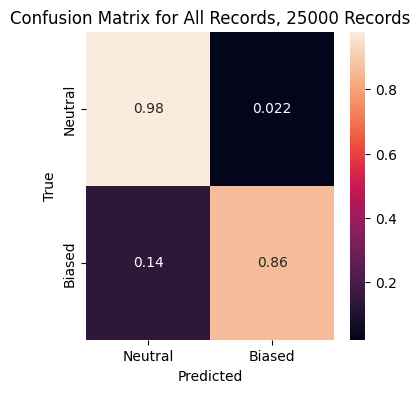

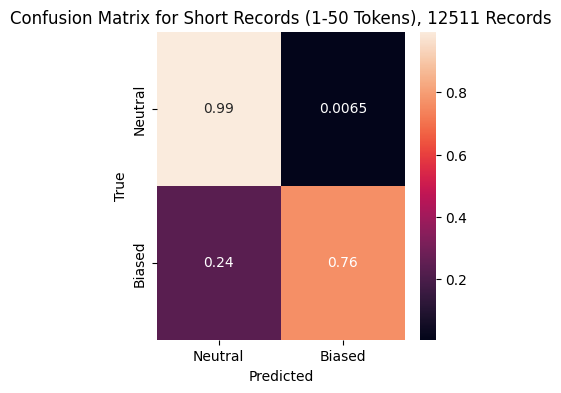

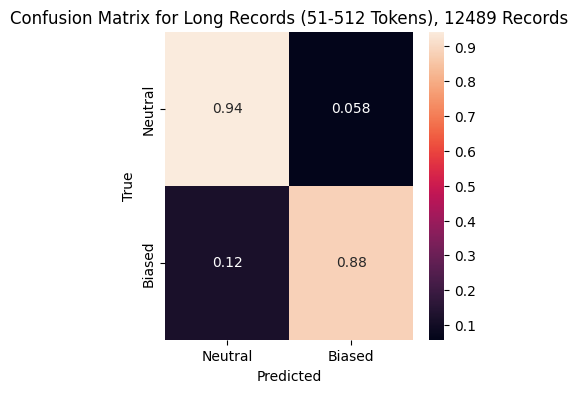

In [34]:
# Plot confusion matrixes for all records, short records, and long records
plot_confusion_matrix(
    all_cm_normalized,
    f"Confusion Matrix for All Records, {len(test_labels)} Records",
)
plot_confusion_matrix(
    short_cm_normalized,
    f"Confusion Matrix for Short Records (1-50 Tokens), {len(test_labels[short_mask])} Records",
)
plot_confusion_matrix(
    long_cm_normalized,
    f"Confusion Matrix for Long Records (51-512 Tokens), {len(test_labels[long_mask])} Records",
)

In [ ]:
# Counts from base df
count_of_biased_and_long = test_df[(test_df["bucket"] == "Long") & (test_df["label_int"] == 1)].shape[0]
print(f"Number of biased + long records: {count_of_biased_and_long}")
count_of_neutral_and_long = test_df[(test_df["bucket"] == "Long") & (test_df["label_int"] == 0)].shape[0]
print(f"Number of neutral + long records: {count_of_neutral_and_long}")

Number of biased + long records: 8080
Number of neutral + long records: 4409


### Named Entity Recognition

In [ ]:
# 1. Multi Label Annotations
multi_label_train = load_dataset("shainar/BEAD", data_files="1-Text-Classification/multi-label.csv")["train"]
multi_label_train_df = multi_label_train.to_pandas()
print("shape:", multi_label_train_df.shape)
multi_label_train_df.head(2)

shape: (16614, 9)


,Original Sentence,BIAS,TOXICITY,SENTIMENT,HARM,DEMOGRAPHIC TARGETING,BIASED WORDS OR PHRASES,Debiased,Annotation
0,"`` 41 , 16 January 2009 ( UTC ) ) : : : : : : ...",No,No,Neutral,Low,None,None,"""During the discussion, there were disagreemen...",Benign
1,: : : : : : : Since I am on friendly terms wit...,No,No,Neutral,Low,None,None,"""Because I have a good relationship with Jimi,...",Benign


In [ ]:
# Drop where "text" is null
multi_label_train_df_cleaned = multi_label_train_df.dropna(subset=["Original Sentence"])
print(f"Dropping null 'text' reduced to {multi_label_train_df_cleaned.shape[0]:,}/{multi_label_train_df.shape[0]:,} rows...")
multi_label_train_df_cleaned["BIAS"].value_counts(dropna=False)

Dropping null 'text' reduced to 16,614/16,614 rows...


,count
BIAS,
No,11819
Yes,4795


In [ ]:
# Calculate the number of characters, tokens, and then bucket into "Short" and "Long"
multi_label_train_df_cleaned["text_len"] = multi_label_train_df_cleaned["Original Sentence"].apply(len)
multi_label_train_df_cleaned["text_tokens"] = (multi_label_train_df_cleaned["text_len"] / 4).round().astype(int)
multi_label_train_df_cleaned["bucket"] = np.where(multi_label_train_df_cleaned["text_tokens"] > MAX_TOKENS_TO_BE_SHORT, "Long", "Short")
multi_label_train_df_cleaned.sample(2)

,Original Sentence,BIAS,TOXICITY,SENTIMENT,HARM,DEMOGRAPHIC TARGETING,BIASED WORDS OR PHRASES,Debiased,Annotation,text_len,text_tokens,bucket
12397,New Page Patrol Hello Thank you for your comme...,Yes,Mild,Negative,Medium,None,"""blatant vandalism"", ""nonsense"", ""obvious infr...","""Hello, thank you for your comments on my talk...",Unsafe,796,199,Short
13615,Reversion Given that some jerk vandalized the ...,No,No,Negative,Low,None,"""jerk""","""Due to an unauthorized modification in the ch...",Unsafe,157,39,Short


In [ ]:
multi_label_train_df_cleaned["bucket"].value_counts(dropna=False)

,count
bucket,
Short,15862
Long,752


In [ ]:
# Shuffle the df
multi_label_train_df_cleaned = multi_label_train_df_cleaned.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)

# Binary label column "label_int"
multi_label_train_df_cleaned["label_int"] = np.where(multi_label_train_df_cleaned["BIAS"] == "Yes", 1, 0)
multi_label_train_df_cleaned["label_int"].value_counts(dropna=False)

,count
label_int,
0,11819
1,4795


In [ ]:
### Convert biased words and phraes string column to list of strings
# Various cleaning to support matching phrases as part of sentence

# Add whitespace around specific punctuation
def add_whitespace_around_punctuation(text):
    pattern = r"(?<!\s)([?!/,])(?!\s)|(?<!\s)([?!/,])|([?!/,])(?!\s)"
    result = re.sub(pattern, r" \1 ", text)
    return re.sub(r"\s+", " ", result).strip()

# Handle for intra-cell note taking
def convert_to_list(cell):
    if not isinstance(cell, str) or not cell.strip():
        return []
    try:
        # Use regex to extract quoted phrases and ignore content outside parentheses
        quoted_phrases = re.findall(r'"(.*?)"', cell)
        processed_phrases = [add_whitespace_around_punctuation(phrase.rstrip(",")) for phrase in quoted_phrases]
        return processed_phrases
    except Exception as e:
        print(f"Error processing cell: {cell} - {e}")
        return []

# Apply processing to bias words/phrases
multi_label_train_df_cleaned["BIAS_PHRASES_V2"] = multi_label_train_df_cleaned["BIASED WORDS OR PHRASES"].fillna("")
multi_label_train_df_cleaned["BIASED_LIST"] = multi_label_train_df_cleaned["BIAS_PHRASES_V2"].apply(convert_to_list)

# Demonstration row
result = multi_label_train_df_cleaned[multi_label_train_df_cleaned["BIAS_PHRASES_V2"].str.contains("lowly style of anime")]
result[["BIASED WORDS OR PHRASES", "BIAS_PHRASES_V2", "BIASED_LIST"]]

,BIASED WORDS OR PHRASES,BIAS_PHRASES_V2,BIASED_LIST
10985,"""lowly style of anime"" (implies a negative vie...","""lowly style of anime"" (implies a negative vie...",[lowly style of anime]


In [ ]:
### Assign O, B, I tags

# Match tokenized phrase within tokenized sentence
def find_sublist(sublist, main_list):
    for i in range(len(main_list) - len(sublist) + 1):
        if main_list[i:i + len(sublist)] == sublist:
            return i
    return -1

# Function to assign B-I-O labels
def generate_bio_labels(row, tokenizer, sentence_col="Original Sentence", biased_list_col="BIASED_LIST"):
    sentence = row[sentence_col]
    biased_list = row[biased_list_col]

    # Tokenize the entire sentence
    sentence_encoded = tokenizer(
        sentence,
        is_split_into_words=False,
        return_offsets_mapping=True,
        truncation=True,
        padding="max_length",
        max_length=MODEL_MAX,
    )
    tokens_with_offsets = sentence_encoded["offset_mapping"]
    sentence_tokens = sentence_encoded["input_ids"]
    sentence_tokens_str = tokenizer.convert_ids_to_tokens(sentence_tokens)

    # Initialize labels, input_ids, and attention_mask
    # NOTE: Assign None/-100 where padding or other special tokens
    ignore_tokens = ("<pad>", "<s>", "</s>", "<mask>", "<unk>")
    bio_labels = [None if tkn in ignore_tokens else "O" for tkn in sentence_tokens_str]
    int_labels = [-100 if tkn in ignore_tokens else 0 for tkn in sentence_tokens_str]
    attention_mask = [0 if tkn in ignore_tokens else 1 for tkn in sentence_tokens_str]

    # Process each phrase in the biased list
    if isinstance(biased_list, list):  # Ensure biased_list is a list
        for phrase in biased_list:
            # phrase_start_idx = sentence.find(phrase)
            phrase_start_idx = sentence.lower().find(phrase.lower())
            if phrase_start_idx == -1:  # Skip if the phrase is not found
                continue
            phrase_end_idx = phrase_start_idx + len(phrase)
            if phrase_end_idx == -1:
              continue

            # Identify the tokens within those offsets
            phrase_token_ids = []
            for i, (start, end) in enumerate(tokens_with_offsets):
                if start >= phrase_start_idx and end <= phrase_end_idx:
                    phrase_token_ids.append(sentence_tokens[i])

            # Decode the phrase tokens back to strings
            phrase_tokens = tokenizer.convert_ids_to_tokens(phrase_token_ids)
            phrase_tokens = [token for token in phrase_tokens if token not in ["<s>", "</s>"]]

            # Find sublist indices
            start_idx = find_sublist(phrase_tokens, sentence_tokens_str)
            if start_idx != -1:
                bio_labels[start_idx] = "B"
                int_labels[start_idx] = 1
                for i in range(1, len(phrase_tokens)):
                    bio_labels[start_idx + i] = "I"
                    int_labels[start_idx + i] = 2

    return sentence_tokens_str, sentence_tokens, bio_labels, int_labels, attention_mask


### Testing with singular row;
### NOTE: Misspelling of "propoganda" a known limitation of dataset's labeling...
# testing_df = multi_label_train_df_cleaned[["Original Sentence", "BIASED_LIST"]].loc[77:77]
# testing_df.at[77, "BIASED_LIST"] = ["Soviet propoganda", "disastrous"]
# testing_df[["tokens", "bio_labels"]] = testing_df.apply(
#     lambda row: pd.Series(generate_bio_labels(row, lf_tokenizer)),
#     axis=1
# )
# testing_df


### Apply the function to the whole DataFrame
multi_label_train_df_cleaned[["tokens", "input_ids", "bio_labels", "labels", "attention_mask"]] = multi_label_train_df_cleaned.apply(
    lambda row: pd.Series(generate_bio_labels(row, lf_tokenizer)),
    axis=1
)
multi_label_train_df_cleaned[["Original Sentence", "BIASED_LIST", "tokens", "input_ids", "bio_labels", "labels", "attention_mask"]].sample(5)

,Original Sentence,BIASED_LIST,tokens,input_ids,bio_labels,labels,attention_mask
2213,How dumb can the school system get . Almost ev...,"[dumb, stupidity]","[<s>, ĠHow, Ġdumb, Ġcan, Ġthe, Ġschool, Ġsyste...","[0, 1336, 16881, 64, 5, 334, 467, 120, 479, 11...","[None, O, B, O, O, O, O, O, O, O, O, O, O, O, ...","[-100, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2406,unfazed by constant acid terrorist attacks by ...,"[constant acid terrorist attacks by Muslims, r...","[<s>, Ġunf, azed, Ġby, Ġconstant, Ġacid, Ġterr...","[0, 9515, 16314, 30, 5891, 10395, 4888, 1912, ...","[None, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2001,When I make edits they vandalize my edits When...,[],"[<s>, ĠWhen, ĠI, Ġmake, Ġedits, Ġthey, Ġvandal...","[0, 520, 38, 146, 39708, 51, 24604, 2072, 127,...","[None, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
9645,larry says date at time a closet raghead is ce...,"[closet raghead, that raghead territory]","[<s>, Ġl, arry, Ġsays, Ġdate, Ġat, Ġtime, Ġa, ...","[0, 784, 12795, 161, 1248, 23, 86, 10, 16198, ...","[None, O, O, O, O, O, O, O, B, I, I, O, O, O, ...","[-100, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, ...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
7501,"Anita Hill said , Biden did `` a disservice to...","[a disservice to me, charges of sexual harassm...","[<s>, ĠAnita, ĠHill, Ġsaid, Ġ,, ĠBiden, Ġdid, ...","[0, 21915, 1934, 26, 2156, 15478, 222, 45518, ...","[None, O, O, O, O, O, O, O, B, I, I, I, I, O, ...","[-100, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 2, 0, ...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [ ]:
# Check for mapped "B" tokens in bio_labels when at least one biased word/phrase
missing_b_df = multi_label_train_df_cleaned[
    (multi_label_train_df_cleaned["BIASED_LIST"].apply(bool)) &
    (multi_label_train_df_cleaned["bio_labels"].apply(lambda x: "B" not in x))
]
print(missing_b_df.shape)

(127, 20)


In [ ]:
### Find where there should be B tokens assigned but aren't
# NOTE: I handled for a lot of these by preprocessing the text
# But some are too niche (e.g., misspellings, unexpected whitespaces, etc.)
# Many are due to bad labeling in the original biased words/phrases data
    # 0, 1, 13614, 77, 211, 251, 466, 921, 1116, 1144, 1166,
    # 1170, 1787, 1845, 2092, 2121, 2125, 3138, 3375, 16104
check_num = 0
print(multi_label_train_df_cleaned.loc[check_num, "Original Sentence"])
print(multi_label_train_df_cleaned.loc[check_num, "tokens"])
print(multi_label_train_df_cleaned.loc[check_num, "bio_labels"])
print(multi_label_train_df_cleaned.loc[check_num, "labels"])
print(multi_label_train_df_cleaned.loc[check_num, "input_ids"])
print(multi_label_train_df_cleaned.loc[check_num, "attention_mask"])
multi_label_train_df_cleaned[["Original Sentence", "BIASED_LIST", "tokens", "input_ids", "bio_labels", "labels", "attention_mask"]].loc[check_num]

what a fucking disgrace having a stephen lawrence day and not a lee rigby day fucking moslem appeasing scum our government and civil servants are spineless bastards giving in to moslem scum and the anti white whites like cunt corbyn and fat black bastard diane flabbott
['<s>', 'Ġwhat', 'Ġa', 'Ġfucking', 'Ġdisgrace', 'Ġhaving', 'Ġa', 'Ġstep', 'hen', 'Ġlaw', 'rence', 'Ġday', 'Ġand', 'Ġnot', 'Ġa', 'Ġle', 'e', 'Ġrig', 'by', 'Ġday', 'Ġfucking', 'Ġmos', 'lem', 'Ġappe', 'asing', 'Ġsc', 'um', 'Ġour', 'Ġgovernment', 'Ġand', 'Ġcivil', 'Ġservants', 'Ġare', 'Ġspin', 'eless', 'Ġbast', 'ards', 'Ġgiving', 'Ġin', 'Ġto', 'Ġmos', 'lem', 'Ġsc', 'um', 'Ġand', 'Ġthe', 'Ġanti', 'Ġwhite', 'Ġwhites', 'Ġlike', 'Ġcunt', 'Ġcor', 'byn', 'Ġand', 'Ġfat', 'Ġblack', 'Ġbastard', 'Ġd', 'iane', 'Ġfl', 'abb', 'ott', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<

,0
Original Sentence,what a fucking disgrace having a stephen lawre...
BIASED_LIST,"[fucking disgrace, moslem appeasing scum, spin..."
tokens,"[<s>, Ġwhat, Ġa, Ġfucking, Ġdisgrace, Ġhaving,..."
input_ids,"[0, 99, 10, 23523, 19846, 519, 10, 1149, 2457,..."
bio_labels,"[None, O, O, B, I, O, O, O, O, O, O, O, O, O, ..."
labels,"[-100, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
attention_mask,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [ ]:
# Compute precision, recall, F1 score, and accuracy for the model's prediction versus the true label
from sklearn.metrics import precision_score, recall_score, f1_score
def compute_metrics(p):
    labels = p.label_ids
    preds = p.predictions.argmax(-1)  # Assuming model outputs logits

    # Flatten the labels and predictions to compute metrics
    true_labels = labels.flatten()
    true_preds = preds.flatten()

    # Exclude padding labels (-100 by convention)
    valid_indices = true_labels != -100
    true_labels = true_labels[valid_indices]
    true_preds = true_preds[valid_indices]

    # Calculate metrics
    precision = precision_score(true_labels, true_preds, average="macro", zero_division=0)
    recall = recall_score(true_labels, true_preds, average="macro", zero_division=0)
    f1 = f1_score(true_labels, true_preds, average="macro", zero_division=0)
    accuracy = (true_preds == true_labels).mean()

    return {"precision": precision, "recall": recall, "f1": f1, "accuracy": accuracy}

In [ ]:
# Reduce to columns to pass to model
sample_ner_df = multi_label_train_df_cleaned[["tokens", "bio_labels", "labels", "input_ids", "attention_mask", "BIAS", "BIASED_LIST"]]

# Train, val, test split and shuffle
sample_n = 4795 * 2

# Balance the dataset to be 50/50 biased and unbiased
biased_subset = sample_ner_df[sample_ner_df["BIAS"] == "Yes"]
neutral_subset = sample_ner_df[sample_ner_df["BIAS"] == "No"]
biased_sampled = biased_subset.sample(n=int(sample_n/2), random_state=RANDOM_STATE)
neutral_sampled = neutral_subset.sample(n=int(sample_n/2), random_state=RANDOM_STATE)
ner_balanced_df = pd.concat([biased_sampled, neutral_sampled])

# Shuffle the combined df
ner_balanced_df = ner_balanced_df.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)
print(f"After balancing biased and unbiased, left with {ner_balanced_df.shape[0]:,}/{sample_ner_df.shape[0]:,} rows")

# Define split sizes
train, test, val = 0.5, 0.25, 0.25

# Calculate indices for splitting
n = ner_balanced_df.shape[0]
train_end = int(n * train)
test_end = train_end + int(n * test)

# Split the DataFrame
train_ner_df = ner_balanced_df.iloc[:train_end]
test_ner_df = ner_balanced_df.iloc[train_end:test_end]
val_ner_df = ner_balanced_df.iloc[test_end:]

# Print the sizes of the splits
print(f"Train size: {len(train_ner_df)}")
print(f"Test size: {len(test_ner_df)}")
print(f"Validation size: {len(val_ner_df)}")
print("")

train_ner_df.head(5)

After balancing biased and unbiased, left with 9,590/16,614 rows
Train size: 4795
Test size: 2397
Validation size: 2398



,tokens,bio_labels,labels,input_ids,attention_mask,BIAS,BIASED_LIST
0,"[<s>, ĠWikipedia, Ġneeds, Ġto, Ġadd, Ġa, ĠNY, ...","[None, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 28274, 782, 7, 1606, 10, 5300, 13459, 50, ...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",No,[]
1,"[<s>, Ġi, Ġknow, Ġthey, Ġare, Ġtrying, Ġto, Ġc...","[None, O, O, O, O, O, O, O, B, I, O, O, O, O, ...","[-100, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, ...","[0, 939, 216, 51, 32, 667, 7, 6225, 1104, 1803...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",Yes,"[white genocide, f ing, muslimes, psycho cult]"
2,"[<s>, ĠUnd, o, ĠGood, Ġjob, Ġundo, ing, Ġand, ...","[None, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 14111, 139, 2497, 633, 22550, 154, 8, 45, ...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",No,[]
3,"[<s>, ĠThe, Ġcitizens, Ġof, Ġthe, ĠUnited, ĠSt...","[None, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 20, 2286, 9, 5, 315, 532, 40, 535, 7, 9215...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",Yes,"[quit wetting themselves in fear, offending th..."
4,"[<s>, ĠI, Ġdont, Ġwant, Ġanything, Ġin, Ġthis,...","[None, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 38, 33976, 236, 932, 11, 42, 1566, 14, 16,...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",Yes,"[generic comments, completely separate critici..."


In [ ]:
print("Overall distribution in sample dataset, across train, validation, and test")
ner_balanced_df["BIAS"].value_counts(dropna=False)

Overall distribution in sample dataset, across train, validation, and test


,count
BIAS,
No,4795
Yes,4795


In [ ]:
print("Distribution in train set")
train_ner_df["BIAS"].value_counts(dropna=False)

Distribution in train set


,count
BIAS,
Yes,2420
No,2375


In [ ]:
print("Distribution in validation set")
val_ner_df["BIAS"].value_counts(dropna=False)

Distribution in validation set


,count
BIAS,
No,1219
Yes,1179


In [ ]:
print("Distribution in test set")
test_ner_df["BIAS"].value_counts(dropna=False)

Distribution in test set


,count
BIAS,
No,1201
Yes,1196


In [ ]:
# LongformerForTokenClassification with custom loss function (to initialize with certain weights)
class CustomLossLongformer(LongformerForTokenClassification):
    def __init__(self, config, class_weights=None, ignore_index=-100):
        super().__init__(config)

        # Define the loss function as an attribute (with ignore_index and optional class weights)
        print("class_weights:", class_weights)
        self.loss_fn = torch.nn.CrossEntropyLoss(
            weight=class_weights,
            ignore_index=ignore_index  # Add ignore_index to handle padding/special tokens
        )

    def forward(self, input_ids, attention_mask=None, labels=None, **kwargs):

        assert torch.max(input_ids) < config.vocab_size, "Invalid index found in input!"

        # Forward pass through the original model
        outputs = super().forward(input_ids, attention_mask=attention_mask, labels=None, **kwargs)
        logits = outputs.logits

        # Compute loss if labels are provided
        loss = None
        if labels is not None:
            # Flatten logits and labels to compute loss at the token level
            loss = self.loss_fn(logits.view(-1, self.config.num_labels), labels.view(-1))
        return TokenClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [ ]:
# Convert pandas DataFrame objects to HuggingFace DataSet objects
train_ner_dataset = Dataset.from_pandas(train_ner_df)
val_ner_dataset = Dataset.from_pandas(val_ner_df)
test_ner_dataset = Dataset.from_pandas(test_ner_df)

# Convert applicable data from lists to torch formatted tensors
train_ner_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
val_ner_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
test_ner_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

In [ ]:
# Confirm that the neccessary data is in torch Tensor form
print(type(train_ner_dataset["tokens"]))
print(type(train_ner_dataset["bio_labels"]))
print(type(train_ner_dataset["labels"]))
print(type(train_ner_dataset["input_ids"]))
print(type(train_ner_dataset["attention_mask"]))

<class 'list'>
<class 'list'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [ ]:
# Visually check if integer labels are correctly aligned to tokens and BIO labels
check_num = 9
print(train_ner_df.loc[check_num, "BIASED_LIST"])
for token, input_id, label, bio_label, in zip(
    train_ner_dataset["tokens"][check_num],
    train_ner_dataset["input_ids"][check_num],
    train_ner_dataset["labels"][check_num],
    train_ner_dataset["bio_labels"][check_num],
):
    print(f"{label} -- Token: {token}, Input ID: {input_id}, BIO Label: {bio_label}")

[]
-100 -- Token: <s>, Input ID: 0, BIO Label: None
0 -- Token: ĠI, Input ID: 38, BIO Label: O
0 -- Token: Ġhate, Input ID: 4157, BIO Label: O
0 -- Token: Ġto, Input ID: 7, BIO Label: O
0 -- Token: Ġsay, Input ID: 224, BIO Label: O
0 -- Token: Ġit, Input ID: 24, BIO Label: O
0 -- Token: Ġbut, Input ID: 53, BIO Label: O
0 -- Token: Ġnot, Input ID: 45, BIO Label: O
0 -- Token: Ġusing, Input ID: 634, BIO Label: O
0 -- Token: Ġgood, Input ID: 205, BIO Label: O
0 -- Token: Ġsources, Input ID: 1715, BIO Label: O
0 -- Token: Ġout, Input ID: 66, BIO Label: O
0 -- Token: Ġof, Input ID: 9, BIO Label: O
0 -- Token: Ġfear, Input ID: 2490, BIO Label: O
0 -- Token: Ġof, Input ID: 9, BIO Label: O
0 -- Token: Ġpublic, Input ID: 285, BIO Label: O
0 -- Token: Ġbacklash, Input ID: 10279, BIO Label: O
0 -- Token: Ġgoes, Input ID: 1411, BIO Label: O
0 -- Token: Ġagainst, Input ID: 136, BIO Label: O
0 -- Token: Ġwhat, Input ID: 99, BIO Label: O
0 -- Token: Ġwik, Input ID: 47764, BIO Label: O
0 -- Token: ipe

In [ ]:
from transformers import TrainerCallback

class CustomEarlyStoppingCallback(TrainerCallback):
    def __init__(self, early_stopping_patience=3, min_epochs=5):
        self.early_stopping_patience = early_stopping_patience
        self.min_epochs = min_epochs
        self.best_metric = None
        self.epochs_without_improvement = 0

    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        if state.epoch < self.min_epochs:
            return  # Skip early stopping until the minimum number of epochs is reached

        # Check the monitored metric
        current_metric = metrics.get("eval_loss", None)
        if current_metric is None:
            return  # Skip if the monitored metric is not available

        if self.best_metric is None or current_metric < self.best_metric:
            self.best_metric = current_metric
            self.epochs_without_improvement = 0
        else:
            self.epochs_without_improvement += 1

        # Stop training if patience is exceeded
        if self.epochs_without_improvement >= self.early_stopping_patience:
            control.should_training_stop = True

In [ ]:
### Prepare the NER model configuration

# Calculate weights according to OBI distribution of entire dataset
all_labels = [label for example in sample_ner_df["labels"] for label in example]
label_counts = Counter(all_labels)
print("label_counts:", label_counts)
if -100 in label_counts:
    del label_counts[-100]
print("After dropping -100 (if applicable), label_counts:", label_counts)
num_labels = len(label_counts)
print("num_labels:", num_labels)

# Compute class weights (inverse frequency)
label_counts = [label_counts.get(i, 0) for i in range(num_labels)]
print("Convert to list, label_counts:", label_counts)
label_pcts = [x/sum(label_counts) for x in label_counts]
print("label_pcts:", label_pcts)
class_weights = [1.0 / count if count > 0 else 0 for count in label_counts]
print("class_weights:", class_weights)

# Convert weights to tensor and move to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)
class_weights = torch.tensor(class_weights).to(device)
print("class_weights tensor:", class_weights)

# Prepare configuration for Longformer model
config = LongformerConfig.from_pretrained(
    "allenai/longformer-base-4096",
    num_labels=3,
)
config.hidden_dropout_prob = 0.3
config.attention_probs_dropout_prob = 0.3

loading configuration file https://huggingface.co/allenai/longformer-base-4096/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/0690955d8f70934f95adf0fb108d5f7322d02f8d7dd938b7b133cb7421e120e6.b25f41ff6acdcb7ab47c505c70e351b3fc01957b3798197e5ac6e8efc547ac99
Model config LongformerConfig {
  "attention_mode": "longformer",
  "attention_probs_dropout_prob": 0.1,
  "attention_window": [
    512,
    512,
    512,
    512,
    512,
    512,
    512,
    512,
    512,
    512,
    512,
    512
  ],
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "ignore_attention_mask": false,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_e

label_counts: Counter({-100: 7261629, 0: 1157862, 2: 63338, 1: 23539})
After dropping -100 (if applicable), label_counts: Counter({0: 1157862, 2: 63338, 1: 23539})
num_labels: 3
Convert to list, label_counts: [1157862, 23539, 63338]
label_pcts: [0.9302046453111857, 0.018910791740276475, 0.050884562948537805]
class_weights: [8.636607816821003e-07, 4.248268830451591e-05, 1.5788310335027944e-05]
device: cuda
class_weights tensor: tensor([8.6366e-07, 4.2483e-05, 1.5788e-05], device='cuda:0')


In [ ]:
# Instantiate a fresh model from checkpoint, assign config and weights
lf_token_classifier_model = CustomLossLongformer.from_pretrained(
    "allenai/longformer-base-4096",
    config=config,
    class_weights=class_weights,
)
lf_token_classifier_model.to(device)

loading weights file https://huggingface.co/allenai/longformer-base-4096/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/a7a586602e625bd012d75abdfcc615f5bb1fe133273845f7381332c634273bd9.dc3a4f03d4ab11f972b126d0e6b67f43e5d9003b3aec54f8e549cc7e2d42398d
/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:1439: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.seria

class_weights: tensor([8.6366e-07, 4.2483e-05, 1.5788e-05], device='cuda:0')


CustomLossLongformer(
  (longformer): LongformerModel(
    (embeddings): LongformerEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(4098, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.3, inplace=False)
    )
    (encoder): LongformerEncoder(
      (layer): ModuleList(
        (0-11): 12 x LongformerLayer(
          (attention): LongformerAttention(
            (self): LongformerSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (query_global): Linear(in_features=768, out_features=768, bias=True)
              (key_global): Linear(in_features=768, out_features=768, bias=True)
              (value_glob

In [ ]:
# Confirm that the input_ids are within the allowable vocab bounds
print("Vocab bounds:", [0, config.vocab_size - 1])
print(f"Max input ID: {torch.max(train_ner_dataset['input_ids'])}")
print(f"Min input ID: {torch.min(train_ner_dataset['input_ids'])}")
print(f"Model vocab size: {lf_token_classifier_model.config.vocab_size}")

Vocab bounds: [0, 50264]
Max input ID: 49922
Min input ID: 0
Model vocab size: 50265


In [ ]:
# Confirm that the training data is within the vocab size
print(lf_tokenizer.vocab_size)
for batch in train_ner_dataset:
    print(min(batch["input_ids"]), max(batch["input_ids"]))
    break
    # print(min(batch["input_ids"]))
    # print(max(batch["input_ids"]))
    # print("")

50265
tensor(0) tensor(35142)


In [ ]:
# Confirm that the model and weights are on the expected device (GPU/cuda or CPU)
print("lf_token_classifier_model.device:", lf_token_classifier_model.device)
print("class_weights.device:", class_weights.device)

lf_token_classifier_model.device: cuda:0
class_weights.device: cuda:0


In [ ]:
### TRAINING

# # Free up memory
# torch.cuda.empty_cache()

# Define training arguments
MAX_EPOCHS = 20
MIN_EPOCHS = 10
EARLY_STOP_PATIENCE = 5
training_args = TrainingArguments(
    output_dir="./results",
    logging_dir="./logs",
    logging_strategy="epoch",
    save_total_limit=3,
    report_to=[],                   # Disable all reporting (e.g., to W&B, TensorBoard)
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=4,  # Had been 16, but read that smaller batches combat overfitting?
    per_device_eval_batch_size=16,
    learning_rate=0.00005,
    num_train_epochs=MAX_EPOCHS,
    metric_for_best_model="f1",     # Choose F1 as the metric to monitor
    load_best_model_at_end=True,
    weight_decay=0.01,
    warmup_steps=100,               # Temporarily taking out warmup steps during debugging
)

# Early stopping callback
early_stopping_callback = CustomEarlyStoppingCallback(
    early_stopping_patience=EARLY_STOP_PATIENCE,
    min_epochs=MIN_EPOCHS
)

# Train model
trainer = Trainer(
    model=lf_token_classifier_model,
    args=training_args,
    train_dataset=train_ner_dataset,
    eval_dataset=val_ner_dataset,
    tokenizer=lf_tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback],
)

trainer.train()

PyTorch: setting up devices
The following columns in the training set  don't have a corresponding argument in `CustomLossLongformer.forward` and have been ignored: BIAS, BIASED_LIST, tokens, bio_labels. If BIAS, BIASED_LIST, tokens, bio_labels are not expected by `CustomLossLongformer.forward`,  you can safely ignore this message.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 4795
  Num Epochs = 20
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 23980


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.815500,0.613799,0.431043,0.730381,0.418999,0.608809
2,0.683300,0.606849,0.440055,0.742737,0.442113,0.652243
3,0.644300,0.647143,0.446856,0.749950,0.454516,0.662205
4,0.619800,0.650487,0.445263,0.743009,0.453128,0.664477
5,0.570600,0.696488,0.435845,0.717818,0.417484,0.588741
6,0.529500,0.729026,0.457325,0.747056,0.477640,0.696252
7,0.503300,0.817767,0.492346,0.745570,0.540487,0.793117
8,0.450400,0.807945,0.488904,0.748730,0.535256,0.784522
9,0.432900,0.944087,0.480955,0.747526,0.523144,0.768654
10,0.406500,0.962671,0.489419,0.747233,0.536277,0.785972


The following columns in the evaluation set  don't have a corresponding argument in `CustomLossLongformer.forward` and have been ignored: BIAS, BIASED_LIST, tokens, bio_labels. If BIAS, BIASED_LIST, tokens, bio_labels are not expected by `CustomLossLongformer.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2398
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-1199
Configuration saved in ./results/checkpoint-1199/config.json
Model weights saved in ./results/checkpoint-1199/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-1199/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-1199/special_tokens_map.json
Deleting older checkpoint [results/checkpoint-169] due to args.save_total_limit
The following columns in the evaluation set  don't have a corresponding argument in `CustomLossLongformer.forward` and have been ignored: BIAS, BIASED_LIST, tokens, bio_labels. If BIAS, BIASED_LIST, toke

TrainOutput(global_step=19184, training_loss=0.4740430738052992, metrics={'train_runtime': 4040.7644, 'train_samples_per_second': 23.733, 'train_steps_per_second': 5.935, 'total_flos': 2.505781607325696e+16, 'train_loss': 0.4740430738052992, 'epoch': 16.0})

In [ ]:
# Evaluate the results; print loss, recall, precision, F1, and accuracy
print(trainer.evaluate())

The following columns in the evaluation set  don't have a corresponding argument in `CustomLossLongformer.forward` and have been ignored: BIAS, BIASED_LIST, tokens, bio_labels. If BIAS, BIASED_LIST, tokens, bio_labels are not expected by `CustomLossLongformer.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2398
  Batch size = 16


{'eval_loss': 1.5007106065750122, 'eval_precision': 0.5231685572091244, 'eval_recall': 0.7197675843543112, 'eval_f1': 0.5771000008663655, 'eval_accuracy': 0.8406567469488508, 'eval_runtime': 25.073, 'eval_samples_per_second': 95.641, 'eval_steps_per_second': 5.983, 'epoch': 16.0}


In [ ]:
lf_ner_weights_path = "/content/drive/My Drive/Berkeley MIDS/DATASCI 266 Natural Language Processing/Models/lf_ner_weights.h5"
# lf_ner_weights_path = "/content/drive/My Drive/Berkeley MIDS/DATASCI 266 Natural Language Processing/Debugging Models/lf_ner_weights.h5"

# Print contents of folder
folder_path = "/content/drive/My Drive/Berkeley MIDS/DATASCI 266 Natural Language Processing/Models"
# folder_path = "/content/drive/My Drive/Berkeley MIDS/DATASCI 266 Natural Language Processing/Debugging Models"
print("Folder contents:", os.listdir(folder_path))

# Save the model state with pytorch
torch.save(lf_token_classifier_model.state_dict(), lf_ner_weights_path)
print("File exists:", os.path.isfile(lf_ner_weights_path))
print("Folder contents:", os.listdir(folder_path))

Folder contents: ['lf_bin_cls_weights_1epoch.h5', 'lf_bin_cls_weights.h5', 'lf_ner_weights_v1.h5', 'lf_ner_weights.h5']
File exists: True
Folder contents: ['lf_bin_cls_weights_1epoch.h5', 'lf_bin_cls_weights.h5', 'lf_ner_weights_v1.h5', 'lf_ner_weights.h5']


In [ ]:
### Prepare NER model from imported weights
lf_token_classifier_model2 = CustomLossLongformer.from_pretrained(
    "allenai/longformer-base-4096",
    config=config,
    class_weights=class_weights,
)
lf_token_classifier_model2.to(device)

# Load the model with pytorch
lf_token_classifier_model2.load_state_dict(torch.load(lf_ner_weights_path))
lf_token_classifier_model2.eval()

loading weights file https://huggingface.co/allenai/longformer-base-4096/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/a7a586602e625bd012d75abdfcc615f5bb1fe133273845f7381332c634273bd9.dc3a4f03d4ab11f972b126d0e6b67f43e5d9003b3aec54f8e549cc7e2d42398d
/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:1439: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.seria

class_weights: tensor([8.6366e-07, 4.2483e-05, 1.5788e-05], device='cuda:0')


<ipython-input-80-d78a836fb30a>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lf_token_classifier_model2.load_state_dict(torch.load(lf_ner_weights_path))


CustomLossLongformer(
  (longformer): LongformerModel(
    (embeddings): LongformerEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(4098, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.3, inplace=False)
    )
    (encoder): LongformerEncoder(
      (layer): ModuleList(
        (0-11): 12 x LongformerLayer(
          (attention): LongformerAttention(
            (self): LongformerSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (query_global): Linear(in_features=768, out_features=768, bias=True)
              (key_global): Linear(in_features=768, out_features=768, bias=True)
              (value_glob

In [ ]:
"""
SAMPLES

#1 -- 1,000 records rstate 1234, 1 epochs, 0.00005 learning rate, ~40  seconds
    Results -- loss: 0.21251, precision: 0.00000, recall: 0.00000, f1: 0.00000, accuracy: 0.94965
#2 -- 1,000 records rstate 1234, 3 epochs0.00005 learning rate, ~101 seconds
    Results -- loss: 0.18000, precision: 0.17614, recall: 0.13478, f1: 0.15271, accuracy: 0.94958
#3 -- 1,000 records rstate 1234, 5 epochs, 0.00005 learning rate, ~161 seconds
    Results -- loss: 0.28049, precision: 0.22511, recall: 0.22609, f1: 0.22559, accuracy: 0.94119

***Increased learning rate to 0.00010 from 0.00005 between samples 3-4
#4 -- 1,000 records rstate 1234, 5 epochs, 0.00010 learning rate, ~164 seconds
    Results -- loss: 0.32785, precision: 0.21757, recall: 0.22609, f1: 0.22174, accuracy: 0.94106

***Added training config [metric_for_best_model="f1"] between samples 4-5
#5 -- 1,000 records rstate 1234, 5 epochs, 0.00010 learning rate, ~162 seconds
    Results -- loss: 0.33574, precision: 0.28042, recall: 0.23043, f1: 0.25298, accuracy: 0.94603

***Filtered data to only records having Bias between samples 5-6; avoid the overfitting to "O" labels
#6 -- 1,000 records rstate 1234, 5 epochs, 0.00010 learning rate, ~163 seconds
    Results -- loss: 0.40451, precision: 0.16484, recall: 0.28360, f1: 0.20849, accuracy: 0.85238

***Upped to sample of 2,000 from 1,000 between samples 6-7
#7 -- 2,000 records rstate 1234, 5 epochs, 0.00010 learning rate, ~306 seconds
    Results -- loss: 0.54471, precision: 0.22571, recall: 0.26795, f1: 0.24502, accuracy: 0.85012

***Added training config [weight_decay=0.01] between samples 7-8
#8 -- 2,000 records rstate 1234, 5 epochs, 0.00010 learning rate, ~305 seconds
    Results -- loss: 0.79124, precision: 0.23696, recall: 0.27372, f1: 0.25402, accuracy: 0.84693
    ^^^Loss still going in the wrong direction^^^

***Added training config [warmup_steps=500] between samples 8-9
#9 -- 2,000 records rstate 1234, 5 epochs, 0.00010 learning rate, ~321 seconds
    Results -- loss: 0.82062, precision: 0.24261, recall: 0.27371, f1: 0.25722, accuracy: 0.85158
    ^^^Loss still going in the wrong direction^^^

***Dropped warmup steps to 100 from 500 between samples 9-10
#10 -- 2,000 records rstate 1234, 5 epochs, 0.00010 learning rate, ~309 seconds
    Results -- loss: 0.83696, precision: 0.26375, recall: 0.25192, f1: 0.25770, accuracy: 0.85354
    ^^^Loss still going in the wrong direction^^^

***Upped to sample of 4,795 from 2,000 between samples 10-11
#11 -- 4,795 records rstate 1234, 5 epochs, 0.00010 learning rate, ~702 seconds
    Results -- loss: 0.54514, precision: 0.27813, recall: 0.28202, f1: 0.28006, accuracy: 0.85114

***Upped to 10 epochs between samples 11-12
#12 -- 4,795 records rstate 1234, 10 epochs, 0.00010 learning rate, ~1400 seconds
    Results -- loss: 0.88756, precision: 0.29709, recall: 0.25951, f1: 0.27703, accuracy: 0.85027

***Back to 5 epochs and 2,000 sample; more aggressive learning of 0.001 from 0.0001 between samples 12-13
#13 -- 2,000 records rstate 1234, 5 epochs, 0.00010 learning rate, ~300 seconds
    Results -- loss: 0.44141, precision: 0.17142, recall: 0.06153, f1: 0.09056, accuracy: 0.86642

***Reduced to batch size 8 from 16 between samples 13-14
#14 -- 2,000 records rstate 1234, 5 epochs, 0.00010 learning rate, ~317 seconds
    Results -- loss: 0.50452, precision: 0.00000, recall: 0.00000, f1: 0.00000, accuracy: 0.85387

***Overrode Longformer config to have 0.3 dropout from default of 0.1 dropout between samples 14-15
#15 -- 2,000 records rstate 1234, 5 epochs, 0.00010 learning rate, ~317 seconds
    Results -- loss: 0.50452, precision: 0.00000, recall: 0.00000, f1: 0.00000, accuracy: 0.85387

***Trying different compute_metrics() function between samples 15-16
#16 -- 2,000 records rstate 1234, 5 epochs, 0.00010 learning rate, ~311 seconds
    Results -- loss: 0.50968, precision: 0.72910, recall: 0.85387, f1: 0.78657, accuracy: 0.17878

***Trying different compute_metrics() function between samples 16-17
#17 -- 2,000 records rstate 1234, 5 epochs, 0.00010 learning rate, ~311 seconds
    Results -- loss: 0.51220, precision: 0.28462, recall: 0.33333, f1: 0.30705, accuracy: 0.85387

***Overrode model loss according to weights of B, I, O frequencies between samples 17-18
#18 -- 2,000 records rstate 1234, 5 epochs, 0.00010 learning rate, ~311 seconds
    Results -- loss: 1.10397, precision: 0.03658, recall: 0.33333, f1: 0.06592, accuracy: 0.10974
#19 -- 2,000 records rstate 1234, 5 epochs, 0.00005 learning rate, ~311 seconds
    Results -- loss: 0.65798, precision: 0.49049, recall: 0.71901, f1: 0.51976, accuracy: 0.70240
#20 -- 2,000 records rstate 1234, 20 epochs, 0.00005 learning rate, ~1234 seconds (20.5 minutes)
    Results -- loss: 1.22156, precision: 0.54420, recall: 0.68004, f1: 0.58721, accuracy: 0.79795

***Added early stopping between samples 20-21
#21 -- 2,000 records rstate 1234, 20 epochs, 0.00005 learning rate, ~799 seconds (13.3 minutes)
    Results -- loss: 1.22967, precision: 0.53382, recall: 0.66875, f1: 0.56997, accuracy: 0.76411

***Reduced to batch size 4 to handle memory issue
#22 -- 2,000 records rstate 1234, 13 epochs, 0.00005 learning rate, ~892 seconds (14.9 minutes)
    Results -- loss: 0.67926, precision: 0.57006, recall: 0.53221, f1: 0.49112, accuracy: 0.84284

***Full run 11/29, batch size 8
#23 -- 9,590 records rstate 1234, 13 epochs, 0.00005 learning rate, ~57 minutes
    Results -- loss: 1.55228, precision: 0.51935, recall: 0.67938, f1: 0.56358, accuracy: 0.81801

***Debugging 11/30, batch size 8
#24 -- 1,000 records rstate 1234, 19 epochs, 0.00005 learning rate, ~8.6 minutes
    Results -- loss: 0.73833, precision: 0.43381, recall: 0.68350, f1: 0.43104, accuracy: 0.64558

***Full run 11/30, batch size 16
#25 -- 9,590 records rstate 1234, 10 epochs, 0.00005 learning rate, ~39 minutes
    Results -- loss: 0.059025, precision: 0.72767, recall: 0.44543, f1: 0.44883, accuracy: 0.90154
#26 -- 9,590 records rstate 5678, 9 epochs, 0.00005 learning rate, ~35 minutes
    Results -- loss: 0.192209, precision: 0.66636, recall: 0.48641, f1: 0.45201, accuracy: 0.89809

***Full run 12/3, batch size 4
#27 -- 9,590 records rstate 1234, 16 epochs, 0.00005 learning rate, ~67 minutes
    Results -- loss: 1.50071, precision: 0.52316, recall: 0.71976, f1: 0.57710, accuracy: 0.84065
"""

NOTE: Accuracy is a misleading metric because there are SO many "O" labels. The dataset is (correctly) very imbalanced. Need to report on this model's performance using F1 score rather than accuracy.

In [ ]:
# TRAIN dataset labels and count
all_labels = [label for example in train_ner_dataset["bio_labels"] for label in example if label != -100]
print("Train label balance:", Counter(all_labels))

# VALIDATION dataset labels and count
all_labels = [label for example in val_ner_dataset["bio_labels"] for label in example if label != -100]
print("Valid label balance:", Counter(all_labels))

# TEST dataset labels and count
all_labels = [label for example in test_ner_dataset["bio_labels"] for label in example if label != -100]
print("Test label balance:", Counter(all_labels))

Train label balance: Counter({None: 2045998, 'O': 369023, 'I': 29559, 'B': 10460})
Valid label balance: Counter({None: 1024410, 'O': 184258, 'I': 14029, 'B': 5079})
Test label balance: Counter({None: 1028170, 'O': 180392, 'I': 13610, 'B': 5092})


In [ ]:
# Trainer obj for reloaded model
trainer2 = Trainer(
    model=lf_token_classifier_model2,
    args=training_args,
    train_dataset=train_ner_dataset,
    eval_dataset=val_ner_dataset,
    tokenizer=lf_tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback],
)

In [ ]:
# Map predictions and labels to NER tags
id_to_label = {0: "O", 1: "B", 2: "I"}
def align_predictions(predictions, label_ids):
    preds = predictions.argmax(axis=2)  # Get the predicted class index
    batch_size, seq_len = preds.shape

    true_predictions = [
        [id_to_label[p] for p, l in zip(preds[i], label_ids[i]) if l != -100]
        for i in range(batch_size)
    ]
    true_labels = [
        [id_to_label[l] for p, l in zip(preds[i], label_ids[i]) if l != -100]
        for i in range(batch_size)
    ]

    return true_predictions, true_labels

# Get predictions from the imported trainer
predictions, label_ids, metrics = trainer2.predict(test_ner_dataset)

# Align predictions and labels
true_predictions, true_labels = align_predictions(predictions, label_ids)

# Compute metrics
print("Classification Report:")
print(seqeval_classification_report(true_labels, true_predictions))
print(f"Accuracy: {accuracy_score(true_labels, true_predictions):.4f}")

The following columns in the test set  don't have a corresponding argument in `CustomLossLongformer.forward` and have been ignored: BIAS, BIASED_LIST, tokens, bio_labels. If BIAS, BIASED_LIST, tokens, bio_labels are not expected by `CustomLossLongformer.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 2397
  Batch size = 16


Classification Report:
              precision    recall  f1-score   support

           _       0.18      0.45      0.26      5092

   micro avg       0.18      0.45      0.26      5092
   macro avg       0.18      0.45      0.26      5092
weighted avg       0.18      0.45      0.26      5092

Accuracy: 0.8443


In [ ]:
# inspect_num = 0
# # len(test_ner_df.reset_index().loc[inspect_num, "tokens"])
# print(len(true_predictions[inspect_num]))
# print(len(true_labels[inspect_num]))
# ignore_tokens = ("<pad>", "<s>", "</s>", "<mask>", "<unk>")
# aglihy = test_ner_df.reset_index().loc[inspect_num, "tokens"]
# aglihy = [a for a in aglihy if a not in ignore_tokens]
# print(len(aglihy))

In [ ]:
test_ner_df.head(1)

,tokens,bio_labels,labels,input_ids,attention_mask,BIAS,BIASED_LIST
4795,"[<s>, ĠHey, ĠJust, Ġwanted, Ġto, Ġsay, Ġthanks...","[None, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 11468, 1801, 770, 7, 224, 2446, 13, 5, 211...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",No,[]


In [ ]:
# Check out a particular input's predictions
ignore_tokens = ("<pad>", "<s>", "</s>", "<mask>", "<unk>")
inspect_num = 3
print("BIAS:", test_ner_df.reset_index().loc[inspect_num, "BIAS"])
print("BIASED_LIST:", test_ner_df.reset_index().loc[inspect_num, "BIASED_LIST"])
drop_pad_and_special = test_ner_df.reset_index().loc[inspect_num, "tokens"]
drop_pad_and_special = [tkn for tkn in drop_pad_and_special if tkn not in ignore_tokens]
inspect_df = pd.DataFrame({
    "tokens":drop_pad_and_special,
    "predictions":true_predictions[inspect_num],
    "true labels":true_labels[inspect_num],
}).T
with pd.option_context("display.max_columns", None):
    display(inspect_df)

BIAS: Yes
BIASED_LIST: ['foolish Liberal tool', 'force up Toronto house prices', 'crater the dollar', 'best and brightest are already fleeing']


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54
tokens,ĠLook,Ġforward,Ġto,Ġa,Ġ65,Ġcent,Ġl,oon,"Ġ,",Ġnot,Ġseen,Ġsince,ĠC,ret,ien,Ġ.,ĠTrump,Ġwill,Ġlikely,Ġand,Ġrightfully,Ġsee,Ġthis,Ġas,Ġcurrency,Ġmanipulation,Ġand,Ġretaliate,Ġ.,ĠPol,oz,Ġis,Ġa,Ġfoolish,ĠLiberal,Ġtool,Ġ.,ĠForce,Ġup,ĠToronto,Ġhouse,Ġprices,Ġand,Ġcrater,Ġthe,Ġdollar,Ġ.,ĠThe,Ġbest,Ġand,Ġbrightest,Ġare,Ġalready,Ġfleeing,Ġ.
predictions,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,B,I,O,B,O,O,O,O,O,B,I,I,O,B,I,I,I,I,O,B,I,I,O,B,B,I,I,I,I,B,O
true labels,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,B,I,I,O,B,I,I,I,I,O,B,I,I,O,O,B,I,I,I,I,I,O


### Predict with Binary Classifier

In [ ]:
# Get the relevant arrays from the Huggingface Dataset, convert to dict
tokenized_test_ner_dict = test_ner_dataset.select_columns(["input_ids", "attention_mask"]).to_dict()

# Rename the keys
tokenized_test_ner_dict["input_ids_layer"] = tokenized_test_ner_dict.pop("input_ids")
tokenized_test_ner_dict["attention_mask_layer"] = tokenized_test_ner_dict.pop("attention_mask")

In [ ]:
# Reassign the labels from the original DataFrame
test_bool = test_ner_df["BIAS"].to_numpy()
test_bool_ints = np.where(test_bool == "Yes", 1, 0)
print(test_bool_ints.shape)

(2397,)


In [ ]:
# Predict for the all records in the test data set
ner_test_data_for_cls = tf.data.Dataset.from_tensor_slices(
    (tokenized_test_ner_dict, test_bool_ints)
    ).batch(8).prefetch(tf.data.AUTOTUNE)
ner_test_cls_preds = lf_model2.predict(ner_test_data_for_cls)

300/300 [==============================] - 73s 185ms/step


In [ ]:
# Convert predictions to 0, 1 based on breakpoint at 0.5
ner_test_cls_pred_labels = ner_test_cls_preds.squeeze()
print("Minimum prediction:", min(ner_test_cls_pred_labels))
print("Maximum prediction:", max(ner_test_cls_pred_labels))
ner_test_cls_pred_labels = (ner_test_cls_pred_labels > 0.5).astype(int)

Minimum prediction: 0.3143889
Maximum prediction: 0.3143889


In [ ]:
uniques, counts = np.unique(ner_test_cls_pred_labels, return_counts=True)
print("Model predictions:")
print(uniques)
print(counts)
# print(f"{uniques[0]}:{counts[0]} ({round(counts[0]/sum(counts)*100, 1)}%)")
# print(f"{uniques[1]}:{counts[1]} ({round(counts[1]/sum(counts)*100, 1)}%)")

Model predictions:
[0]
[2397]


In [ ]:
predicted_df = test_ner_df.copy()
predicted_df["predictions"] = true_predictions

In [ ]:
# Assign prediction float and label columns
predicted_df["bin_cls_pred_lbl"] = ner_test_cls_pred_labels
predicted_df["bin_cls_pred_pct"] = ner_test_cls_preds
predicted_df.sample(2)

,tokens,bio_labels,labels,input_ids,attention_mask,BIAS,BIASED_LIST,predictions,bin_cls_pred_lbl,bin_cls_pred_pct
5238,"[<s>, ĠYour, Ġsubmission, Ġat, ĠAf, C, ĠDone, ...","[None, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 2486, 13127, 23, 6710, 347, 21220, 9487, 4...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",No,[],"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",0,0.314389
4991,"[<s>, Ġ``, ĠI, Ġam, Ġmuch, Ġhappier, Ġ...., Ġ'...","[None, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 45518, 38, 524, 203, 16265, 39574, 12801, ...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",Yes,"[ex-Catholic, the old country, compelled to te...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",0,0.314389


### Predictions to CSV

In [ ]:
# Write predictions to CSV
predicted_df.to_csv("sample_model_predictions.csv")